# Задача 5. Обучение без учителя

### Задача

1. Найти данные с количеством признаков хотя бы 50, на которых можно решить
задачу кластеризации.
2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
3. Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
4. Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).
При обучении использовать подбор гиперпараметров.
5. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.

6. (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
7. (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

In [93]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [105]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score

## 1. Датасет


Для задачи возьмем датасет с Kaggle c 96 числом признаков [Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction). Данные в датасете были собраны из Taiwan Economic Journal за 1999–2009 годы, отражающие банкротство компаний на основе правил ведения бизнеса Тайваньской фондовой биржи.

In [44]:
df = pd.read_csv("/content/data.csv")
df = df.sample(frac=1).reset_index(drop=True)

In [45]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0.485107,0.544265,0.531720,0.603461,0.603468,0.999015,0.797407,0.809323,0.303460,...,0.798981,0.001906,0.623813,0.603461,0.840348,0.282668,0.028244,0.568075,1,0.022353
1,0,0.552430,0.593600,0.597409,0.630371,0.630371,0.999255,0.797816,0.809632,0.303671,...,0.830871,0.012047,0.623789,0.630370,0.842279,0.277307,0.026800,0.565199,1,0.047102
2,0,0.392873,0.461077,0.455967,0.601263,0.602372,0.998394,0.796582,0.808708,0.303316,...,0.760327,0.000561,0.623985,0.601261,0.837809,0.277093,0.026781,0.565107,1,0.050378
3,0,0.436699,0.504416,0.490230,0.605140,0.605140,0.998937,0.797294,0.809238,0.303425,...,0.779289,0.000953,0.623799,0.605136,0.838991,0.277148,0.026783,0.565117,1,0.049476
4,0,0.567445,0.621130,0.606831,0.607100,0.606920,0.999039,0.797777,0.809603,0.304056,...,0.843893,0.002123,0.624268,0.607100,0.843208,0.277589,0.026793,0.565167,1,0.043524


## 2. EDA

In [46]:
df.shape

(6819, 96)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [48]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [49]:
[print(col) for col in df if df[col].isna().sum() > 0]

[]

Можно заметить, что NULL-ов в данных нет. Проверим на дубликаты

In [50]:
df.duplicated().sum()

0

Дубликатов тоже в данных нет

In [52]:
print(df['Bankrupt?'].value_counts())

Bankrupt?
0    6599
1     220
Name: count, dtype: int64


Можно заметить, что данные не сбалансированы.


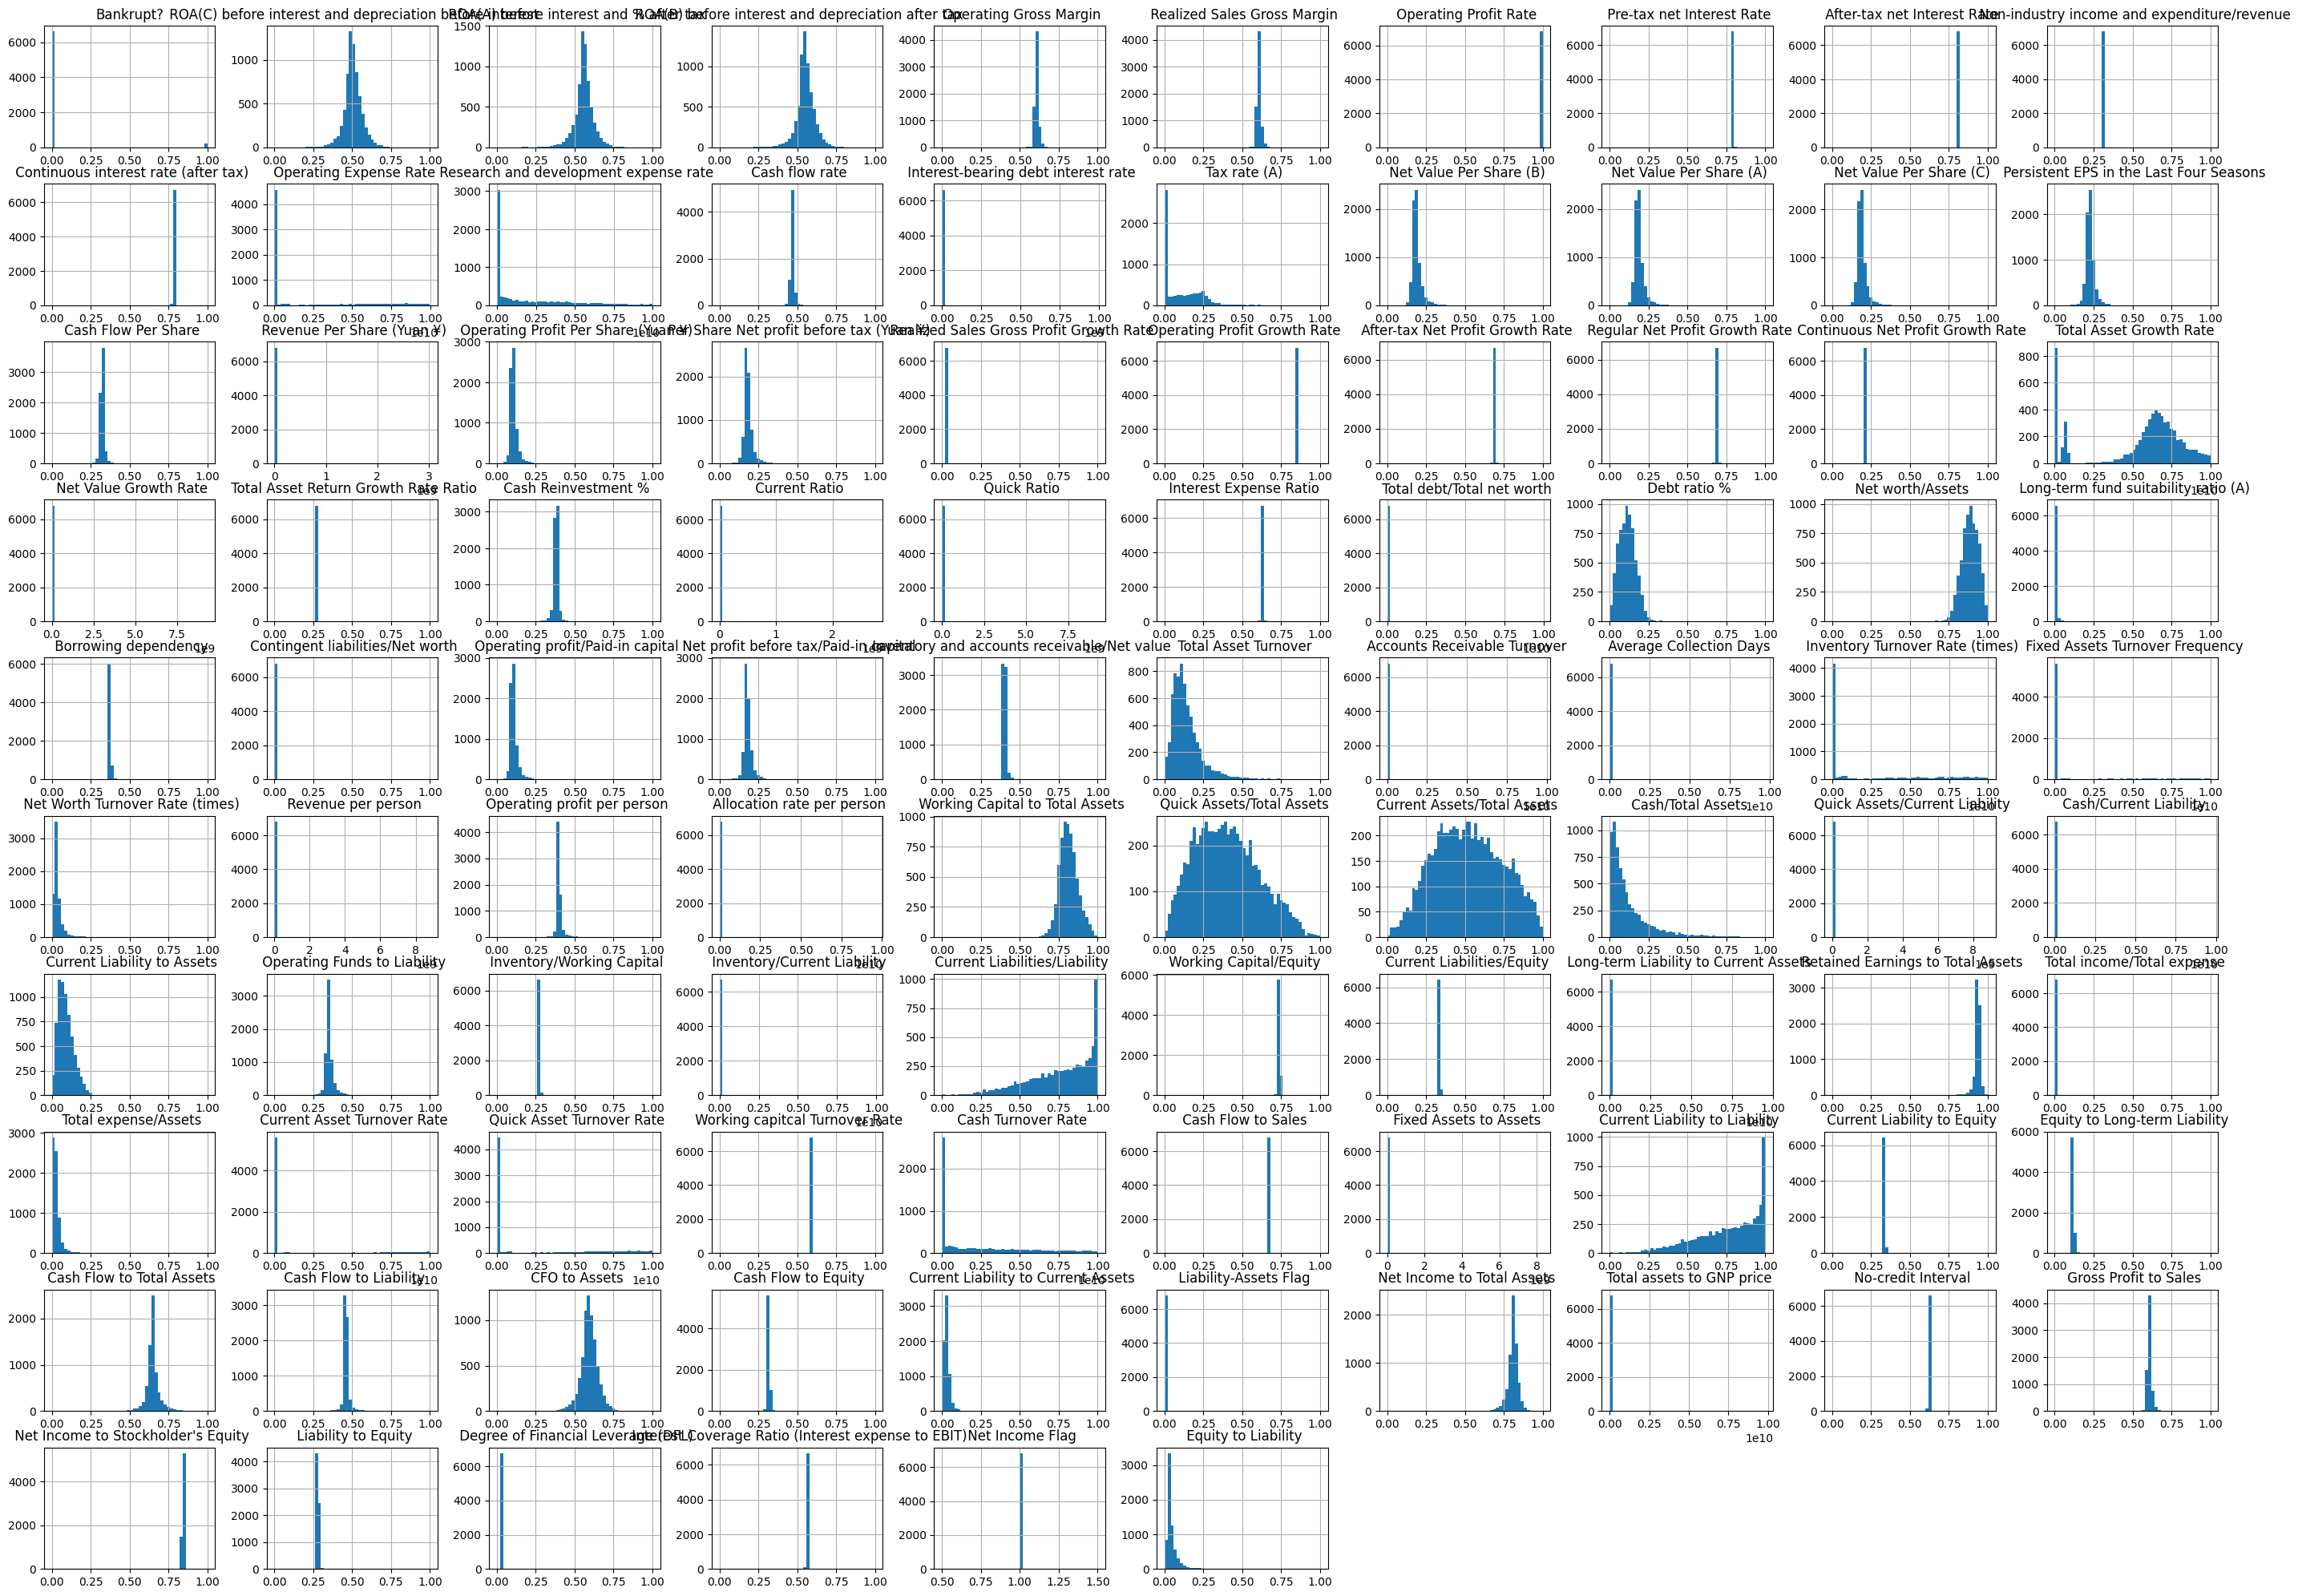

In [53]:
df.hist(figsize = (35,25), bins = 50)
plt.show()

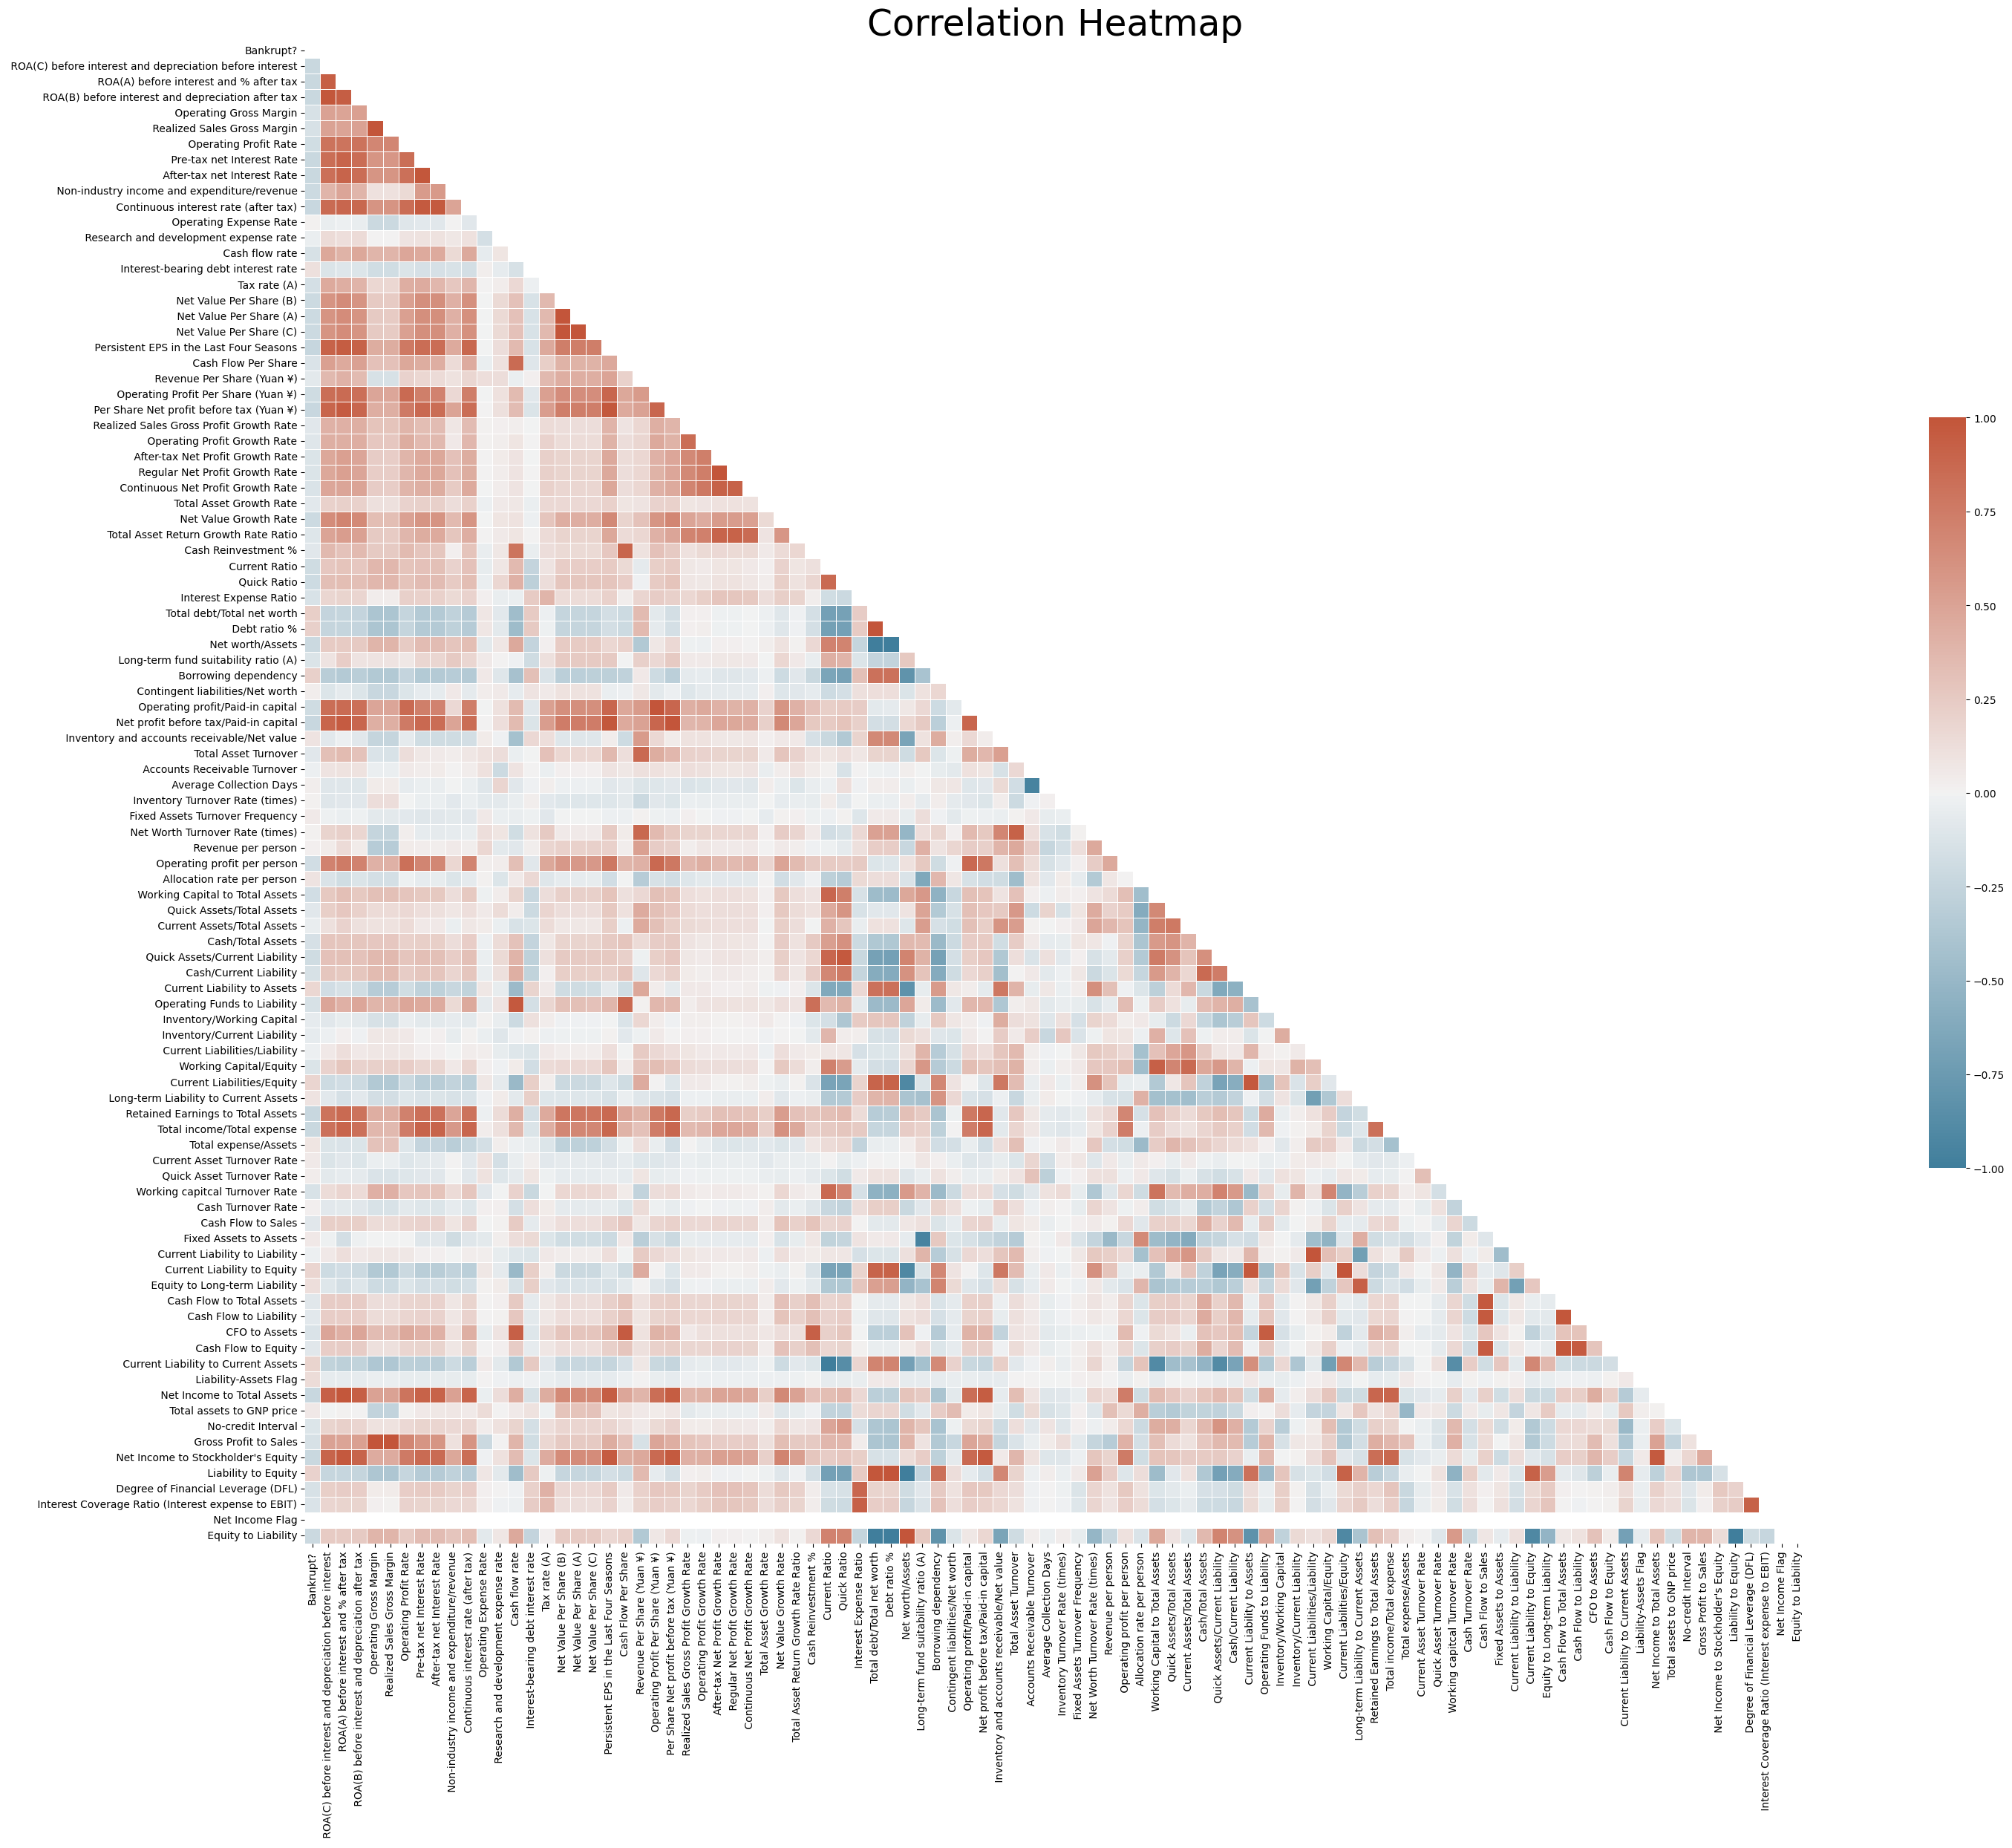

In [57]:
f,ax = plt.subplots(figsize=(35, 25))

mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat,dtype=bool))
cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(mat,mask=mask,cmap=cmap,vmax=1,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

plt.title('Correlation Heatmap',fontsize=35)

plt.tight_layout()

plt.show()

У некоторых признаков есть сильная корреляция (*R > 0.9* или *R < -0.9* )

In [58]:
features = df.drop('Bankrupt?', axis=1).columns

In [59]:
list1 = features
list2 = features
list_int = []
count = 1

for col1 in list1:
    list_int.append(col1)
    for col2 in list2:
        if col2 not in list_int:
            R_corr = df.corr().loc[col1,col2]
            if R_corr > 0.9 or R_corr < -0.9:
                print(count,'.  ',col1,' -- ',col2,';  R = {:.3f}'.format(R_corr))
                count += 1

1 .    ROA(C) before interest and depreciation before interest  --   ROA(A) before interest and % after tax ;  R = 0.940
2 .    ROA(C) before interest and depreciation before interest  --   ROA(B) before interest and depreciation after tax ;  R = 0.987
3 .    ROA(A) before interest and % after tax  --   ROA(B) before interest and depreciation after tax ;  R = 0.956
4 .    ROA(A) before interest and % after tax  --   Net Income to Total Assets ;  R = 0.962
5 .    ROA(B) before interest and depreciation after tax  --   Net Income to Total Assets ;  R = 0.912
6 .    Operating Gross Margin  --   Realized Sales Gross Margin ;  R = 1.000
7 .    Operating Gross Margin  --   Gross Profit to Sales ;  R = 1.000
8 .    Realized Sales Gross Margin  --   Gross Profit to Sales ;  R = 1.000
9 .    Operating Profit Rate  --   Pre-tax net Interest Rate ;  R = 0.916
10 .    Operating Profit Rate  --   Continuous interest rate (after tax) ;  R = 0.916
11 .    Pre-tax net Interest Rate  --   After-tax net

In [61]:
columns_to_delete = {' ROA(A) before interest and % after tax',
               ' ROA(C) before interest and depreciation before interest',
               ' Per Share Net profit before tax (Yuan ¥)',
               ' Net profit before tax/Paid-in capital',
               ' Debt ratio %',
               ' Liability to Equity'}

In [63]:
new_columns = list(set(df.columns) - columns_to_delete)
df = df[new_columns]

In [64]:
df.shape

(6819, 90)

In [71]:
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## PCA

<ipython-input-116-17c6cf3ecd47>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, alpha=0.7, s=20, cmap=plt.cm.get_cmap('plasma'))


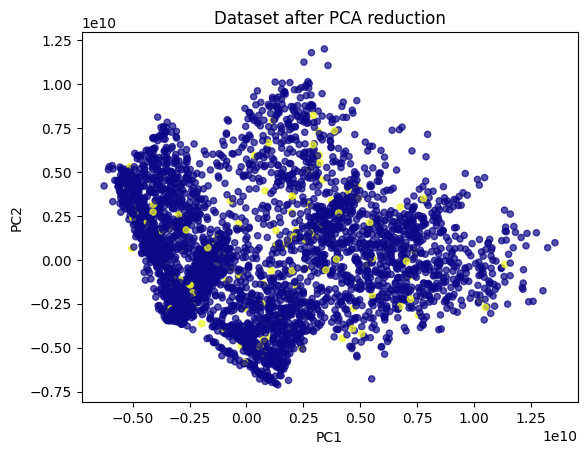

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, alpha=0.7, s=20, cmap=plt.cm.get_cmap('plasma'))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset after PCA reduction');
plt.show()

In [ ]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## t-SNE

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
tsne = tsne.fit_transform(X_train_scaled)

<ipython-input-89-c70e60b11dd1>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('plasma'),


Text(0.5, 1.0, 'Dataset after t-SNE reduction')

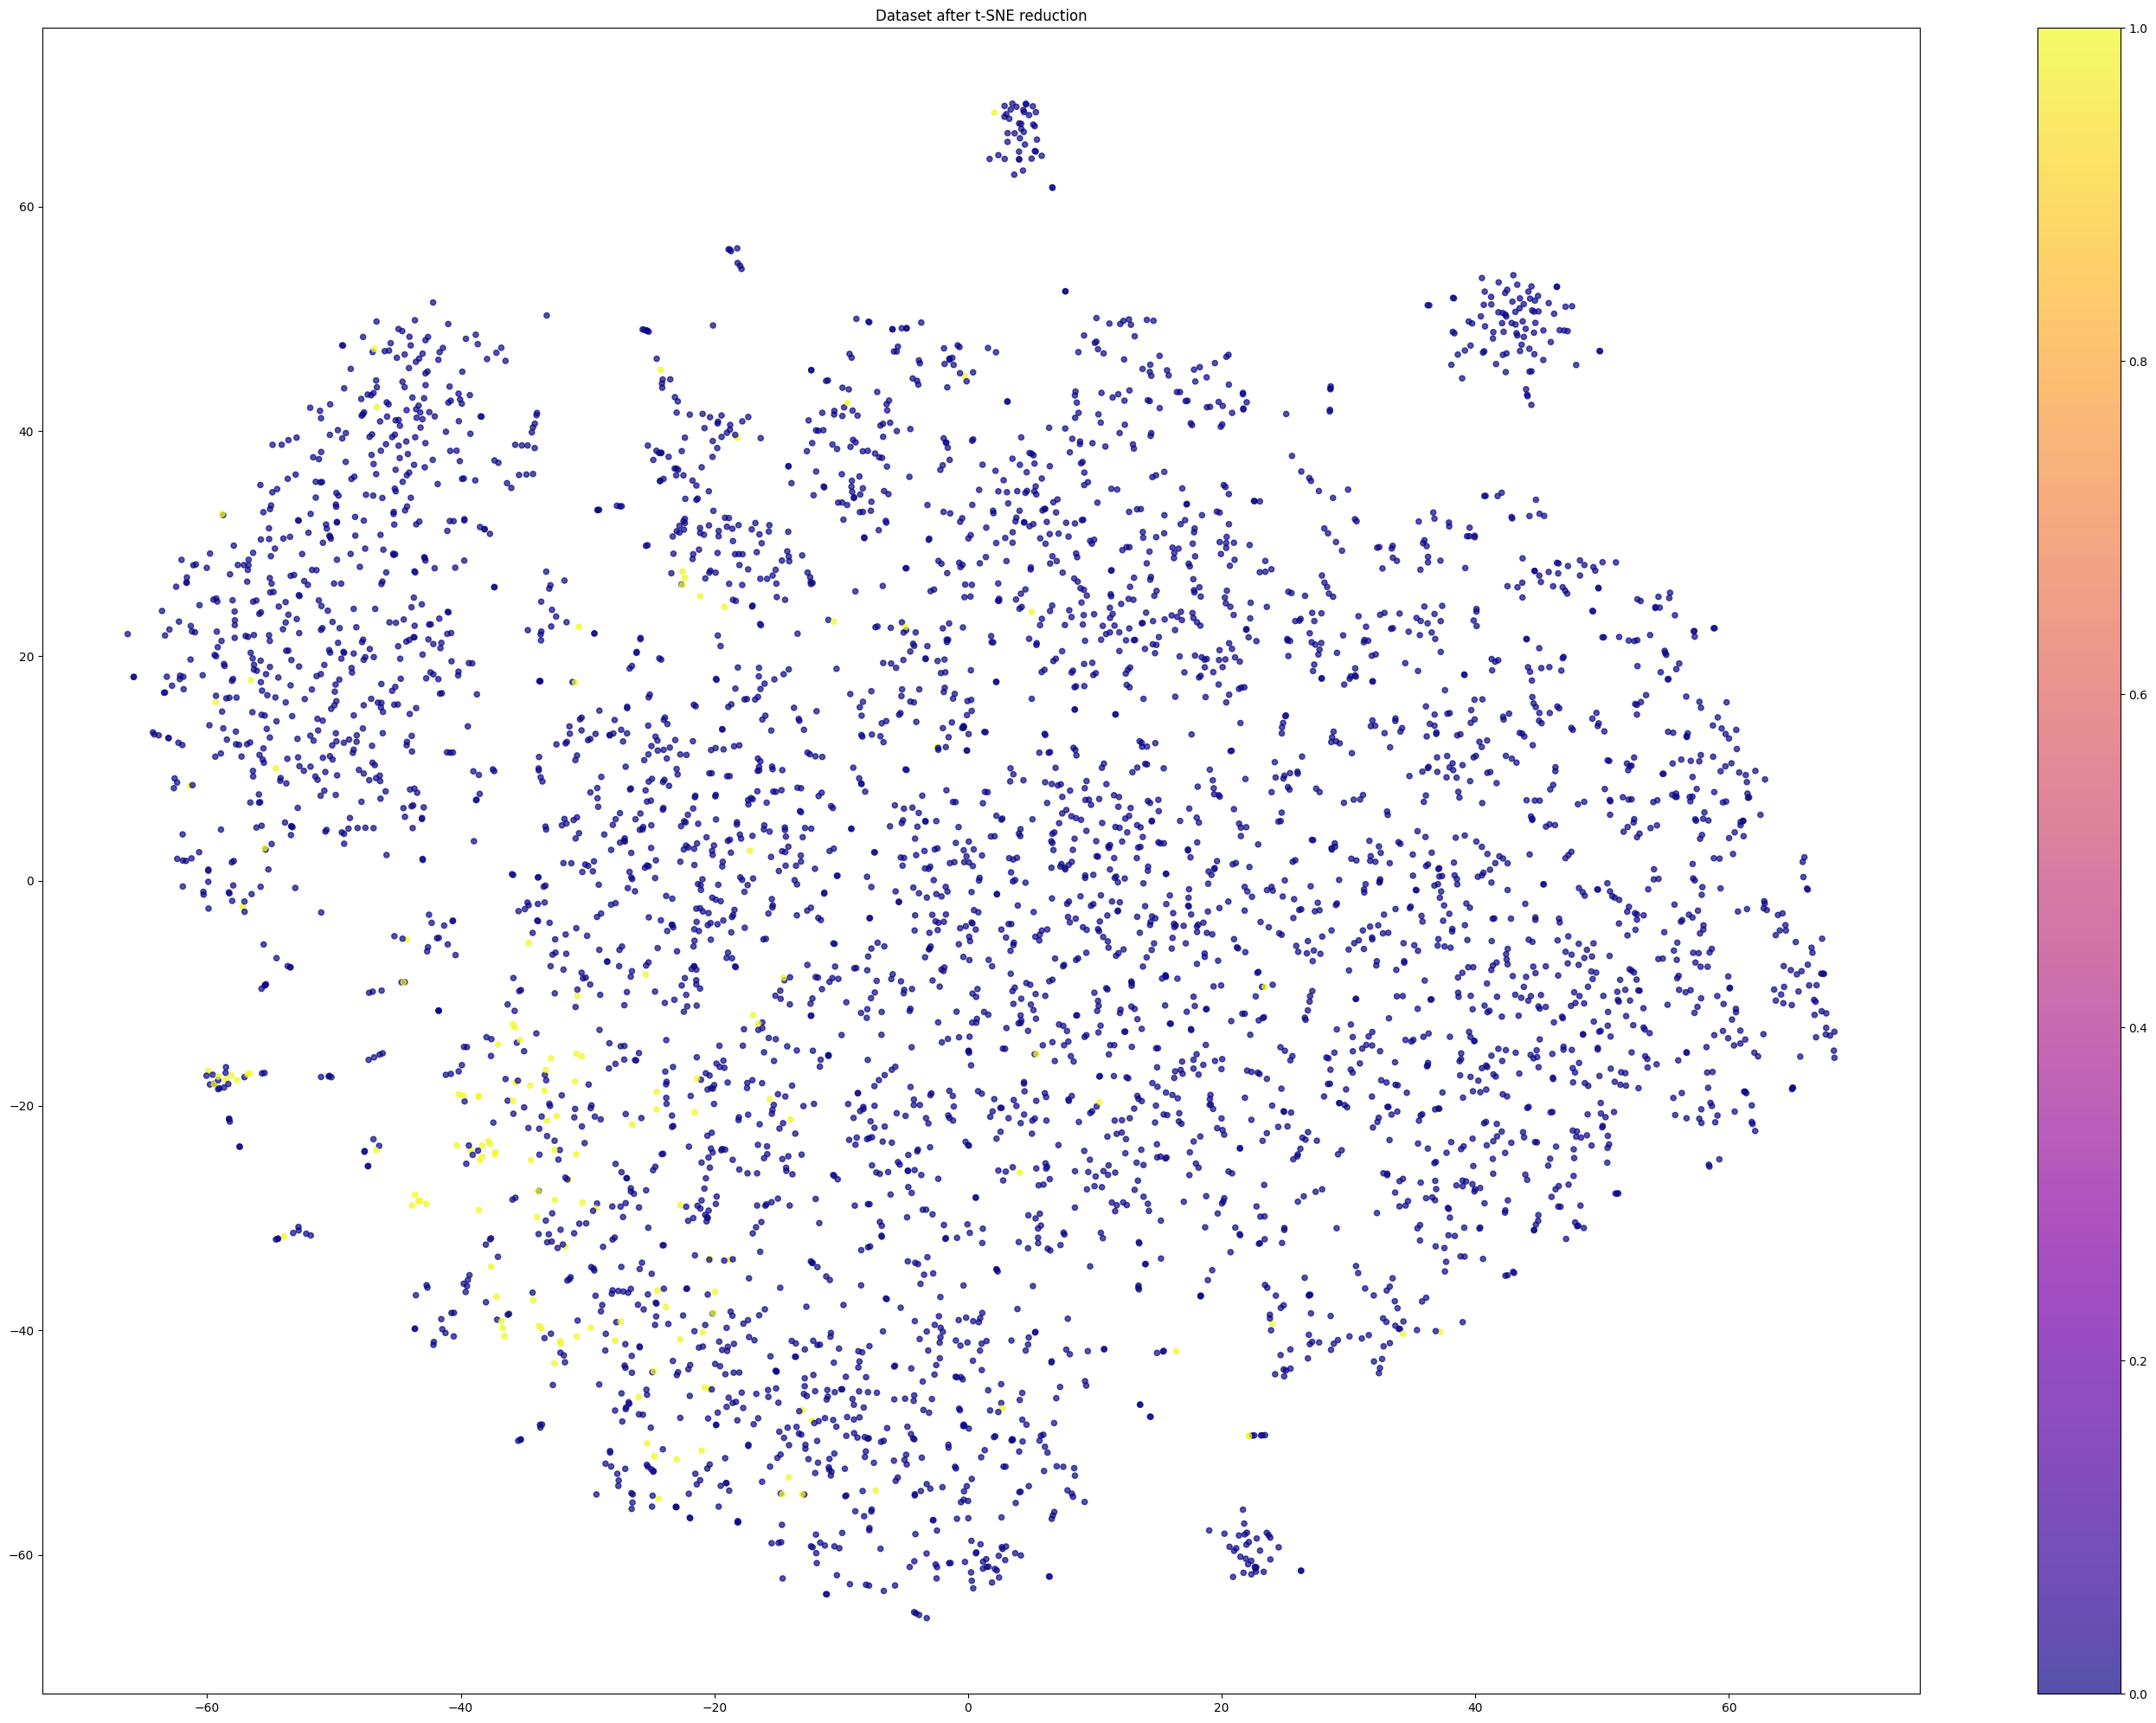

In [89]:
plt.figure(figsize=(35, 25))
plt.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c=y_train,
    alpha=0.7,
    s=20,
    cmap=plt.cm.get_cmap('plasma'),
)
plt.colorbar()
plt.title("Dataset after t-SNE reduction")

## Самостоятельная реализация алгоритма кластеризации K-means

In [106]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels = np.argmin(distances, axis=0)

            new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.n_clusters)])

            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
          X = X.values

        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

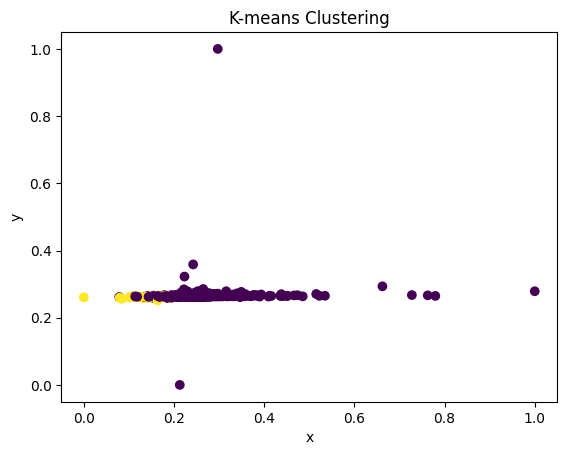

In [107]:
kmeans = CustomKMeans(n_clusters=2, max_iter=10000)
kmeans.fit(X_train)

labels = kmeans.predict(X_test)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-means Clustering')
plt.show()

In [108]:
def get_model_score(model, params, X_train, X_test, dbscan=False):
    grid_search = GridSearchCV(model, params, scoring='adjusted_mutual_info_score', cv=3, n_jobs=-1)
    grid_search.fit(X_train)

    model = model.set_params(**grid_search.best_params_)

    start = datetime.now()
    if dbscan:
        predictions = model.fit_predict(X_train)
        true_vals = y_train
    else:
        model.fit(X_train)
        predictions = model.predict(X_test)
        true_vals = y_test
    end = datetime.now()


    adj_rand_score = adjusted_rand_score(true_vals, predictions)
    adj_mut_info_score = adjusted_mutual_info_score(true_vals, predictions)
    homogen_score = homogeneity_score(true_vals, predictions)
    comp_score = completeness_score(true_vals, predictions)

    scores = dict()
    scores['adj_rand_score'] = adj_rand_score
    scores['adj_mut_info_score'] = adj_mut_info_score
    scores['homogen_score'] = homogen_score
    scores['comp_score'] = comp_score
    scores['training_time'] = end - start

    return scores

In [119]:
model = CustomKMeans(n_clusters=2)
params = {
    'max_iter': np.logspace(0, 10, base=2.0, num=10, dtype=int)
}
non_pca_score = get_model_score(model, params, X_train, X_test)
pca_score = get_model_score(model, params, X_train_pca, X_test_pca)

results = [non_pca_score, pca_score]
df_my_kmeans = pd.DataFrame.from_records(results)
df_my_kmeans['model'] = 'CustomKMeans'
df_my_kmeans['pca'] = ['no_pca', 'pca']
df_my_kmeans

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time,model,pca
0,0.015085,0.000534,0.002741,0.000862,0 days 00:00:00.010706,CustomKMeans,no_pca
1,0.005631,0.000137,0.001973,0.000468,0 days 00:00:00.001895,CustomKMeans,pca


In [121]:
params = {
    'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0],
    'init': ['random', 'k-means++'],
    'max_iter': [100, 500, 1000, 2000],
}
model = KMeans(n_clusters=2)

non_pca_score = get_model_score(model, params, X_train, X_test)
pca_score = get_model_score(model, params, X_train_pca, X_test_pca)
results = [non_pca_score, pca_score]
df_kmeans = pd.DataFrame.from_records(results)
df_kmeans['model'] = 'sk_learn_KMeans'
df_kmeans['pca'] = ['no_pca', 'pca']
df_kmeans

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time,model,pca
0,0.008209,0.000302,0.002371,0.000595,0 days 00:00:00.205590,sk_learn_KMeans,no_pca
1,0.005221,-0.000269,0.000952,0.000240,0 days 00:00:00.026670,sk_learn_KMeans,pca


In [123]:
params = {
    'eps': np.arange(0.25, 1.0, step=0.05),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'min_samples': np.arange(2, 10, step=1),
}

model = DBSCAN()

non_pca_score = get_model_score(model, params, X_train, X_test, dbscan=True)
pca_score = get_model_score(model, params, X_train_pca, X_test_pca)

results = [non_pca_score, pca_score]
df_dbscan = pd.DataFrame.from_records(results)
df_dbscan['model'] = 'DBSCAN'
df_dbscan['pca'] = ['no_pca', 'pca']
df_dbscan

KeyboardInterrupt: 